## Birth weight prediction

Using Tensorflow to predict if the weight of a new born child is correct or under the mean.

#### Model 
- Regression problem
- Metric is accuracy
- Using 3 hidden layers.

Library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests

session = tf.Session()
%config Completer.use_jedi = False

Dataset import

In [2]:
url = 'https://raw.githubusercontent.com/joanby/tensorflow/master/datasets/birthweight.csv'
birth_file = requests.get(url)
birth_data = birth_file.text.split('\r\n')

birth_header = birth_data[0].split(',')
birth_data = [[float(x) for x in y.split(',') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]

Features and label split

In [3]:
print(birth_header)

['LOW', 'AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI', 'BWT']


In [4]:
y_vals = np.array([x[8] for x in birth_data])
x_vals = np.array([x[1:8] for x in birth_data])

Random state seed 

In [5]:
seed = 2019
tf.set_random_seed(seed)
np.random.seed(seed)
batch_size = 100

#### Train/test dataset split

In [6]:
train_idx = np.random.choice(a = len(x_vals), size = round(len(x_vals)*0.8), replace = False)
test_idx = np.array(list(set(range(len(x_vals)))-set(train_idx)))

x_vals_train = x_vals[train_idx]
y_vals_train = y_vals[train_idx]

x_vals_test = x_vals[test_idx]
y_vals_test = y_vals[test_idx]

#### Dataset normalization.

In [7]:
def normalize_col(m, col_min = np.array([None]), col_max = np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis = 0)
    if not col_max[0]:
        col_max = m.max(axis = 0)
    return (m - col_min)/(col_max-col_min), col_min, col_max

x_vals_train, train_min, train_max = np.nan_to_num(normalize_col(x_vals_train))
x_vals_test,_,_ = np.nan_to_num(normalize_col(x_vals_test, train_min, train_max))

/home/juan/anaconda3/lib/python3.7/site-packages/numpy/lib/type_check.py:461: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = _nx.array(x, subok=True, copy=copy)


#### Tensorflow variable declaration

First we define 2 generic functions to return a distribution variable using a given shape and std dev.
$Weight$ is going to be used to initialize the weights of the neural network and $bias$ to initialize the bias value of every layer.

In [8]:
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape = shape, stddev= st_dev))
    return weight

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape = shape, stddev = st_dev))
    return bias

Feature and label placeholders

In [9]:
x_data = tf.placeholder(shape = [None, 7], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

Function to automatize the hidden layers operation

In [10]:
def full_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(layer)

Now lets define the size of every hidden layer and then run the generic functions to create them.
- Input value size : 7 -> hidden layer_1 size : 25. First layer have 7*25+25 = 200 variables
- Hidden layer_1 size : 25 -> Hidden layer_2 size : 10. Second layer have 25*10+10 = 260 variables
- Hidden layer_2 size : 10 -> Hidden layer_3 size : 3. Third layer have 10*3+3 = 33 variables.
- Hidden layer 3 size : 3 -> Hidden layer_4 size : 1. Fourth layer have 3*1+1 = 4 variables.

In total we have 497 variables!

Layers definition:

In [11]:
w1 = init_weight(shape = [7,25], st_dev= 10.0)
b1 = init_bias(shape = [25], st_dev= 10.0)
layer1 = full_connected(x_data, w1, b1)

w2 = init_weight(shape = [25,10], st_dev= 10.0)
b2 = init_bias(shape = [10], st_dev= 10.0)
layer2 = full_connected(layer1, w2, b2)

w3 = init_weight(shape = [10,3], st_dev= 10.0)
b3 = init_bias(shape = [3], st_dev= 10.0)
layer3 = full_connected(layer2, w3, b3)

w4 = init_weight(shape = [3,1], st_dev= 10.0)
b4 = init_bias(shape = [1], st_dev= 10.0)
layer4 = full_connected(layer3, w4, b4)

Loss function using Adam optimizer

In [12]:
loss = tf.reduce_mean(tf.abs(y_target - layer4))
my_optim = tf.train.AdamOptimizer(0.05)
train_step = my_optim.minimize(loss)

Variable initialization

In [24]:
init = tf.global_variables_initializer()
session.run(init)

### Model training

In [25]:
train_loss = []
test_loss = []
train_acc = []
for i in range(300):
    rand_idx = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_idx]
    rand_y = np.transpose([y_vals_train[rand_idx]])
    
    session.run(train_step, feed_dict = {x_data: rand_x,
                                         y_target: rand_y})
    train_temp_loss = session.run(loss, feed_dict = {x_data: rand_x,
                                               y_target: rand_y})
    train_loss.append(train_temp_loss)
    
    test_temp_loss = session.run(loss, feed_dict = {x_data: x_vals_test,
                                                    y_target: np.transpose([y_vals_test])})
    test_loss.append(test_temp_loss)
    
    temp_acc = 
    
    if (i+1)%30 == 0:
        print('Step #'+str(i+1)+
              'Loss: '+str(train_temp_loss))

Step #30Loss: 94350.93
Step #60Loss: 10038.403
Step #90Loss: 1972.9727
Step #120Loss: 1903.3882
Step #150Loss: 2590.4783
Step #180Loss: 1320.6964
Step #210Loss: 4082.98
Step #240Loss: 1435.2206
Step #270Loss: 1330.1188
Step #300Loss: 1570.5228


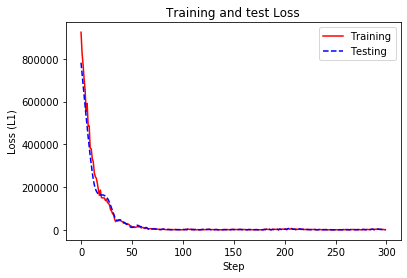

In [26]:
plt.plot(train_loss, 'r-', label = 'Training')
plt.plot(test_loss, 'b--', label = 'Testing')
plt.title('Training and test Loss')
plt.xlabel('Step')
plt.ylabel('Loss (L1)')
plt.legend(loc = 'upper right')
plt.show()

### Model evaluation

In [29]:
actuals = np.array([x[0] for x in birth_data])
test_actuals = actuals[test_idx]
train_actuals = actuals[train_idx]
test_pred = [x[0] for x in session.run(layer4, feed_dict= {x_data: x_vals_test})]
train_pred = [x[0] for x in session.run(layer4, feed_dict = {x_data: x_vals_train})]
test_pred = np.array([1.0 if x<2500.0 else 0.0 for x in test_pred])
train_pred = np.array([1.0 if x<2500.0 else 0.0 for x in train_pred])

In [30]:
test_acc = np.mean([x==y for x,y in zip(test_pred, test_actuals)])
train_acc = np.mean([x==y for x,y in zip(train_pred, train_actuals)])

print('Test accuracy: '+str(test_acc))
print('Train accuracy: '+str(train_acc))

Test accuracy: 0.5
Train accuracy: 0.5960264900662252
